In [1]:
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import numpy as np
import albumentations as A

import matplotlib.pyplot as plt
import glob
from dotenv import load_dotenv
from PIL import Image
import cv2
from pathlib import Path

import pandas as pd
import shutil

DATASET_PATH = "./Multi_change/data/archive"
NEW_DATASET_PATH = './Multi_change/data/forest_cover/'

/opt/anaconda3/envs/forestchat/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
%load_ext dotenv
%dotenv -o

In [13]:

for dataset in ["train", "val", "test"]:
    data = pd.read_csv(DATASET_PATH + "/" + f'{dataset}.csv')

    for idx, row in data.iterrows():
        file_id = f"{idx + 1:06d}"

        img_A_path = os.path.join(DATASET_PATH, "images", row["dir"], row["img_1"])
        img_B_path = os.path.join(DATASET_PATH, "images", row["dir"], row["img_2"])
        label_path = os.path.join(DATASET_PATH, "images", row["label"])

        img_A_dest = os.path.join(NEW_DATASET_PATH, "images", dataset, "A", f"{dataset}_{file_id}.png")
        img_B_dest = os.path.join(NEW_DATASET_PATH, "images", dataset, "B", f"{dataset}_{file_id}.png")
        label_dest = os.path.join(NEW_DATASET_PATH, "images", dataset, "label", f"{dataset}_{file_id}.png")

        try:
            shutil.copy(img_A_path, img_A_dest)
            shutil.copy(img_B_path, img_B_dest)
            shutil.copy(label_path, label_dest)
        except FileNotFoundError as e:
            print(f"Missing file at row {idx} (ID: {file_id}): {e}")


FileNotFoundError: [Errno 2] No such file or directory: './Multi_change/data/archive/train.csv'

In [14]:
BASE_DATA_DIR = os.environ.get("BASE_DATA_DIR", "Multi_change/data/Forest-Change-dataset")
EXAMPLES_FOLDER = os.environ.get("EXAMPLES_FOLDER", "images")


In [46]:
import albumentations as A

def get_image_transforms():
    transform = A.Compose(
        [
            A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.8),
            A.RandomGamma(gamma_limit=(80, 120), p=0.8),
            A.ColorJitter(
                brightness=0.1, contrast=0.1, saturation=0.1, hue=0.02, p=0.9
            ),
            A.GaussianBlur(blur_limit=(3, 3), sigma_limit=0.5, p=0.6),
            A.GaussNoise(
                std_range=(0.02, 0.06),
                mean_range=(0, 0),
                per_channel=True,
                noise_scale_factor=1.0,
                p=0.6,
            ),
        ],
        additional_targets={"image_B": "image"},
    )
    return transform

def visualise_images_and_mask(split, file_num):
    file_id = f"{file_num + 0:06d}"
    imgA = Image.open(os.path.join(BASE_DATA_DIR, EXAMPLES_FOLDER, split, 'A', f'{split}_{file_id}.png'))
    imgB = Image.open(os.path.join(BASE_DATA_DIR, EXAMPLES_FOLDER, split, 'B', f'{split}_{file_id}.png'))
    mask = Image.open(os.path.join(BASE_DATA_DIR, EXAMPLES_FOLDER, split, 'label', f'{split}_{file_id}.png'))

    plt.figure(figsize=(15,5))

    plt.subplot(1,3,1)
    plt.imshow(imgA)
    plt.title("Image A")
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.imshow(imgB)
    plt.title("Image B")
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.imshow(mask)
    plt.title("Mask")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

def visualise_images(split, file_num):
    file_id = f"{file_num + 0:06d}"
    imgA = Image.open(os.path.join(BASE_DATA_DIR, EXAMPLES_FOLDER, split, 'A', f'{split}_{file_id}.png'))
    imgB = Image.open(os.path.join(BASE_DATA_DIR, EXAMPLES_FOLDER, split, 'B', f'{split}_{file_id}.png'))

    plt.figure(figsize=(10,5))

    plt.subplot(1,2,1)
    plt.imshow(imgA)
    plt.title("Image A")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(imgB)
    plt.title("Image B")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


def visualise_augmented_images_and_mask(split, file_num):
    file_id = f"{file_num:06d}"
    pathA = os.path.join(BASE_DATA_DIR, EXAMPLES_FOLDER, split, 'A', f'{split}_{file_id}.png')
    pathB = os.path.join(BASE_DATA_DIR, EXAMPLES_FOLDER, split, 'B', f'{split}_{file_id}.png')
    pathM = os.path.join(BASE_DATA_DIR, EXAMPLES_FOLDER, split, 'label', f'{split}_{file_id}.png')

    # Load images and mask
    imgA = np.array(Image.open(pathA).convert("RGB"))
    imgB = np.array(Image.open(pathB).convert("RGB"))
    mask = np.array(Image.open(pathM))

    # Apply augmentations
    transform = get_image_transforms()
    augmented = transform(image=imgA, image_B=imgB)
    imgA_aug = augmented['image']
    imgB_aug = augmented['image_B']

    # Plot original and augmented
    fig, axs = plt.subplots(2, 3, figsize=(8, 6))

    images = [imgA, imgB, mask, imgA_aug, imgB_aug, mask]
    titles = ["Original A", "Original B", "Mask",
              "Augmented A", "Augmented B", "Mask (Unchanged)"]

    for ax, img, title in zip(axs.flatten(), images, titles):
        ax.imshow(img)
        ax.set_title(title, fontsize=10)
        ax.axis("off")

    # Reduce space between subplots
    plt.subplots_adjust(wspace=0.05, hspace=0.15)
    plt.tight_layout(pad=1.0)
    plt.show()

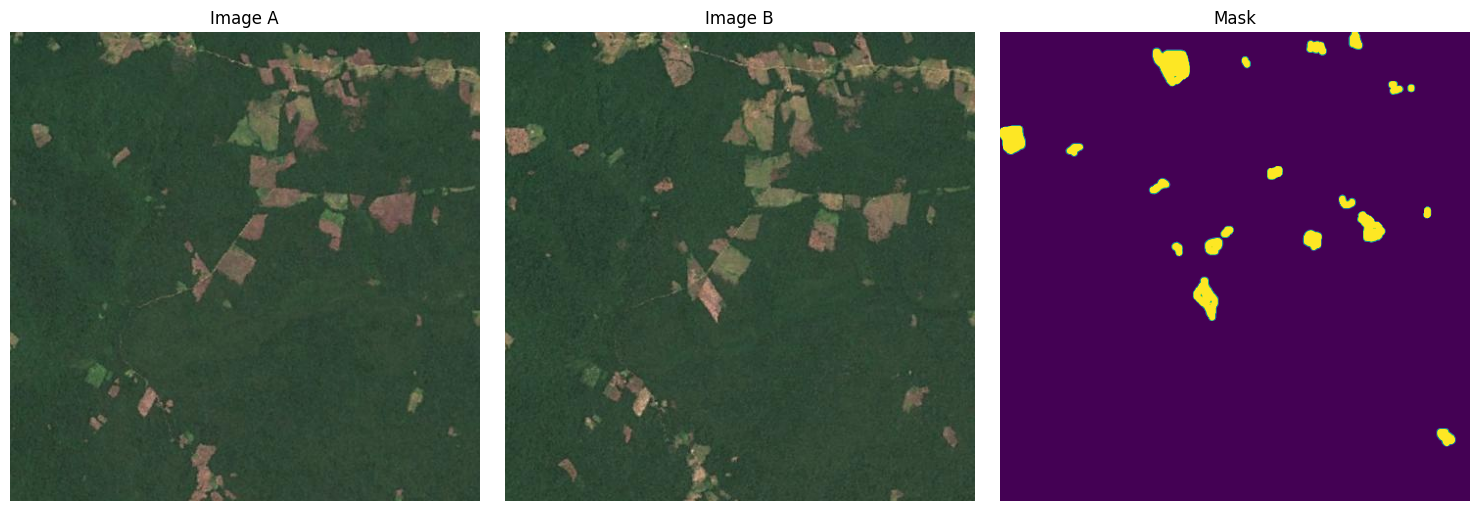

In [26]:
visualise_images_and_mask("val", 1)

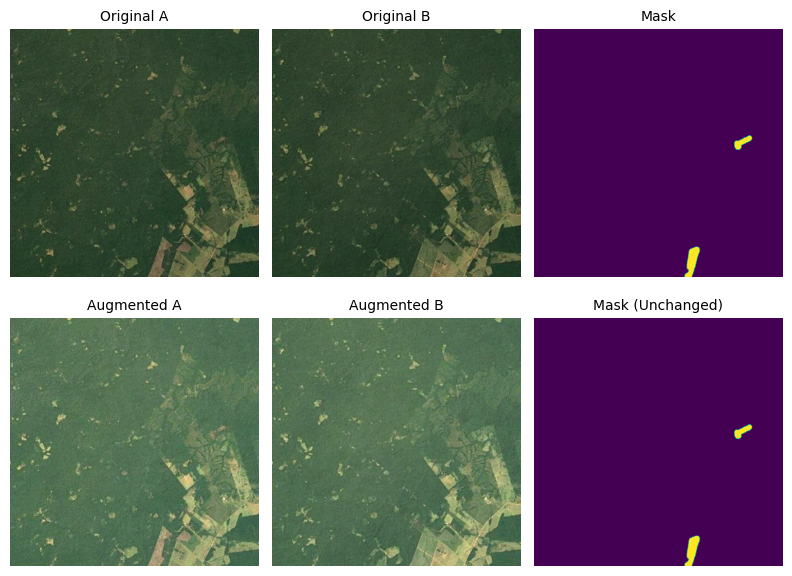

In [53]:
visualise_augmented_images_and_mask("train", 250)

In [ ]:
from skimage.io import imread
from torchange.models.segment_any_change import AnyChange, show_change_masks

def test_sac(split, file_num):
    file_id = f"{file_num + 0:06d}"
    imgA_path = os.path.join(BASE_DATA_DIR, EXAMPLES_FOLDER, split, 'A', f'{split}_{file_id}.png')
    imgB_path = os.path.join(BASE_DATA_DIR, EXAMPLES_FOLDER, split, 'B', f'{split}_{file_id}.png')

    imgA = imread(imgA_path)
    imgB = imread(imgB_path)

    m = AnyChange('vit_h', sam_checkpoint='./Multi_change/models_ckpt/sam_vit_h_4b8939.pth')
    m.make_mask_generator(
        points_per_side=16,
        stability_score_thresh=0.95,
    )

    m.set_hyperparameters(
        change_confidence_threshold=155,
        use_normalized_feature=True,
        bitemporal_match=True,
    )

    changemasks, _, _ = m.forward(imgA, imgB)
    fig, axes = show_change_masks(imgA, imgB, changemasks)

    plt.show()

test_sac("val", 1)


(480, 480, 3)


KeyboardInterrupt: 

In [2]:
import os
import numpy as np
from PIL import Image
from tqdm import tqdm

class ImageStatsCalculator:
    """
    Loads ALL A and B images into one combined array for statistics calculation.
    Folder structure:
    dataset_root/
    └── images/
        ├── train/
        │   ├── A/
        │   └── B/
        ├── val/
        │   ├── A/
        │   └── B/
        └── test/
            ├── A/
            └── B/
    """
    
    def __init__(self, base_folder, img_size=(256, 256)):
        self.base_folder = base_folder
        self.img_size = img_size
        self.all_images = []  # Will store all loaded images
        self.all_labels = []
        self._load_images()

    def _load_images(self):
        # Find all splits (train/val/test)
        splits = [d for d in ["train", "val", "test"] 
                if os.path.isdir(os.path.join(self.base_folder, "images", d))]
        
        for split in splits:
            split_path = os.path.join(self.base_folder, "images", split)
            
            # Load all A images
            a_folder = os.path.join(split_path, "A")
            for img_file in tqdm(os.listdir(a_folder), desc=f"Loading {split}/A"):
                if img_file.startswith('.'): continue
                img = self._load_single_image(os.path.join(a_folder, img_file))
                self.all_images.append(img)
            
            # Load all B images 
            b_folder = os.path.join(split_path, "B")
            for img_file in tqdm(os.listdir(b_folder), desc=f"Loading {split}/B"):
                if img_file.startswith('.'): continue
                img = self._load_single_image(os.path.join(b_folder, img_file))
                self.all_images.append(img)

            label_folder = os.path.join(split_path, "label")
            for img_file in tqdm(os.listdir(label_folder), desc=f"Loading {split}/label"):
                if img_file.startswith("."): continue
                img = self._load_single_mask(os.path.join(label_folder, img_file))
                self.all_labels.append(img)


    def _load_single_image(self, path):
        """Load and preprocess single image"""
        img = Image.open(path).convert('RGB')
        img = img.resize(self.img_size)
        return np.array(img) / 255.0  # Normalize to [0,1]
    
    def _load_single_mask(self, path):
        """Load single grayscale mask and convert to binary (0=background, 1=foreground)"""
        mask = Image.open(path).convert('L')  # Force grayscale
        mask = np.array(mask)
        return (mask > 0).astype(np.uint8)  # Convert to binary

    def calculate_stats(self):
        """Calculate mean and std for all images (combined A+B)"""
        if not self.all_images:
            raise ValueError("No images loaded!")
            
        # Convert to single numpy array (N, H, W, 3)
        image_stack = np.stack(self.all_images)
        
        # Calculate stats
        mean = np.round(np.mean(image_stack, axis=(0, 1, 2)), 5)  # Mean per channel
        std = np.round(np.std(image_stack, axis=(0, 1, 2)), 5)   # Std per channel
        
        return mean, std
    
    def calculate_detailed_mask_stats(self):
        """Calculate comprehensive mask statistics including per-image distribution"""
        per_image_foreground = []
        per_image_background = []
        hist_bins = np.linspace(0, 100, 21)  # 5% bins for histogram
        
        for label in self.all_labels:
            binary_mask = (label != 0).astype(np.uint8)
            total_pixels = binary_mask.size
            fg_pixels = np.sum(binary_mask == 1)
            fg_percent = (fg_pixels / total_pixels) * 100
            
            per_image_foreground.append(fg_percent)
            per_image_background.append(100 - fg_percent)
        
        # Convert to numpy arrays for calculations
        fg_percents = np.array(per_image_foreground)
        bg_percents = np.array(per_image_background)
        
        # Calculate statistics
        stats = {
            'foreground': {
                'min': float(np.min(fg_percents)),
                'max': float(np.max(fg_percents)),
                'mean': float(np.mean(fg_percents)),
                'median': float(np.median(fg_percents)),
                'std': float(np.std(fg_percents)),
                'histogram': {
                    'bins': hist_bins.tolist(),
                    'counts': np.histogram(fg_percents, bins=hist_bins)[0].tolist()
                }
            },
            'background': {
                'min': float(np.min(bg_percents)),
                'max': float(np.max(bg_percents)),
                'mean': float(np.mean(bg_percents)),
                'median': float(np.median(bg_percents)),
                'std': float(np.std(bg_percents))
            },
            'aggregate': {
                'foreground_percent': float(np.mean(fg_percents)),
                'background_percent': float(np.mean(bg_percents)),
                'ratio': float(np.mean(bg_percents) / np.mean(fg_percents)) 
                        if np.mean(fg_percents) != 0 else float('inf')
            }
        }
        
        return stats

# Usage:
BASE_FOLDER = "./Multi_change/data/Forest-Change-dataset"
calculator = ImageStatsCalculator(BASE_FOLDER)


Loading test/label: 100%|██████████| 33/33 [00:00<00:00, 972.62it/s]


Mean (RGB): [0.2267  0.29982 0.22058]
Std (RGB): [0.0923  0.06658 0.05681]

Label Statistics:
{'foreground': {'min': 0.015625, 'max': 39.35329861111111, 'mean': 4.810730102295409, 'median': 3.23046875, 'std': 5.354200860924012, 'histogram': {'bins': [0.0, 5.0, 10.0, 15.0, 20.0, 25.0, 30.0, 35.0, 40.0, 45.0, 50.0, 55.0, 60.0, 65.0, 70.0, 75.0, 80.0, 85.0, 90.0, 95.0, 100.0], 'counts': [213, 82, 20, 10, 6, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}}, 'background': {'min': 60.64670138888889, 'max': 99.984375, 'mean': 95.18926989770458, 'median': 96.76953125, 'std': 5.354200860924012}, 'aggregate': {'foreground_percent': 4.810730102295409, 'background_percent': 95.18926989770458, 'ratio': 19.78686558455766}}


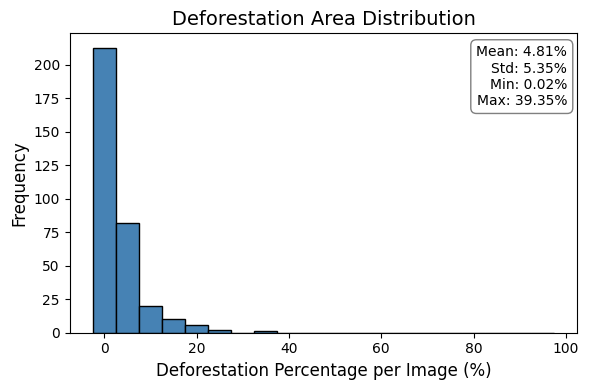

In [9]:
mean, std = calculator.calculate_stats()

print(f"Mean (RGB): {mean}")
print(f"Std (RGB): {std}")


print("\nLabel Statistics:")
stats = calculator.calculate_detailed_mask_stats()
print(stats)

import matplotlib.pyplot as plt

# Prepare data
bins = stats['foreground']['histogram']['bins']
counts = stats['foreground']['histogram']['counts']
mean_fg = stats['foreground']['mean']
std_fg = stats['foreground']['std']
min_fg = stats['foreground']['min']
max_fg = stats['foreground']['max']

# Create figure and axis
fig, ax = plt.subplots(figsize=(6, 4))

# Plot histogram
ax.bar(bins[:-1], counts, width=(bins[1] - bins[0]),
       edgecolor='black', color='steelblue')

# Titles and labels
ax.set_title("Deforestation Area Distribution", fontsize=14)
ax.set_xlabel("Deforestation Percentage per Mask (%)", fontsize=12)
ax.set_ylabel("Frequency", fontsize=12)
ax.tick_params(labelsize=10)

# Summary box text
summary_text = (
    f"Mean: {mean_fg:.2f}%\n"
    f"Std: {std_fg:.2f}%\n"
    f"Min: {min_fg:.2f}%\n"
    f"Max: {max_fg:.2f}%"
)

# Add the info box in the top-right corner
ax.text(0.98, 0.96, summary_text,
        transform=ax.transAxes,
        fontsize=10,
        verticalalignment='top',
        horizontalalignment='right',
        bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.4'))

# Tight layout and show
plt.tight_layout()
plt.show()




In [71]:
import json
import os
import cv2
import numpy as np
from tqdm import tqdm
import random
import re

LOSS_ADJECTIVES = {
    (0, 1): [
        "negligible forest loss is detected",
        "almost no forest change is observed",
        "very minimal forest degradation",
    ],
    (1, 5): [
        "minor forest loss is visible",
        "slight forest degradation is noted",
        "small amounts of forest loss are apparent",
        "limited deforestation observed",
    ],
    (5, 10): [
        "low levels of forest degradation are observed",
        "some modest forest loss is detected",
        "slight forest loss is apparent",
    ],
    (10, 15): [
        "moderate forest loss is present",
        "noticeable forest degradation occurs",
        "intermediate deforestation is evident",
    ],
    (15, 25): [
        "substantial deforestation has occurred",
        "considerable forest loss is visible",
        "significant forest loss is observed",
    ],
    (25, 40): [
        "extensive forest loss is detected in the observed area",
        "large-scale forest degradation is apparent",
        "widespread clearings are present",
    ],
    (40, 65): [
        "severe deforestation affects a large portion of the scene",
        "major forest loss dominates the area",
        "heavy deforestation is visible throughout much of the region",
    ],
    (65, 85): [
        "critical forest loss dominates the region",
        "an overwhelming level of deforestation is evident",
        "very high levels of deforestation detected",
    ],
    (85, 100): [
        "near-total deforestation is observed throughout the area",
        "almost complete loss of forest detected",
        "forest cover is nearly entirely removed",
    ]
}

POSITIONS = [
    "top-left", "top-center", "top-right",
    "middle-left", "center", "middle-right",
    "bottom-left", "bottom-center", "bottom-right"
]

LOCATION_PHRASES = {
    "single": [
        "concentrated in the {pos} region",
        "mainly located in the {pos} area",
        "primarily found in the {pos} section",
    ],
    "dual": [
        "primarily occurring in the {pos1} and {pos2} regions",
        "mainly located across the {pos1} and {pos2} areas",
        "largely concentrated in the {pos1} and {pos2} sections",
    ],
    "scattered": [
        "scattered across multiple regions",
        "distributed throughout various parts of the area",
        "spread across several different regions",
    ]
}

PATCH_VARIABILITY = {
    "low": [
        "uniform in size",
        "relatively consistent in patch size"
    ],
    "medium": [
        "moderately varied in size",
        "showing some variation in patch size"
    ],
    "high": [
        "highly varied in size",
        "displaying large variations in patch sizes"
    ]
}

PATCH_COUNT_PHRASES = {
    "few": [
        "in a few patches that are {var}",
        "in a small number of patches which are {var}"
    ],
    "several_extensive": [
        "in several patches, including one or more extensive regions, being {var}",
        "in multiple patches with some large areas, that are {var}"
    ],
    "multiple_notable": [
        "in multiple patches, including some notable regions, which are {var}",
        "distributed among several patches with some notable sizes, that are {var}"
    ],
    "many_small": [
        "in many small patches, being {var}",
        "scattered in numerous small patches, which are {var}"
    ]
}

TEMPLATES = [
            "{adj}, {distribution}, {patchiness}",
            "{distribution}, {adj}, {patchiness}",
            "{adj} and {distribution}, {patchiness}",
            "{adj} - {patchiness}, {distribution}",
            "{adj}",
            "{adj}, {distribution}",
            "{adj}, {patchiness}",
            "{distribution}, {adj}"
        ]

class CaptionUpdater:
    def __init__(self, json_path, images_base_folder):
        self.json_path = json_path
        self.images_base_folder = images_base_folder
        self.data = self.load_json()
        
    def load_json(self):
        with open(self.json_path, 'r') as f:
            return json.load(f)
    
    def save_json(self, output_path=None):
        save_path = output_path or self.json_path
        with open(save_path, 'w') as f:
            json.dump(self.data, f, indent=2)
        print(f"Saved updated captions to {save_path}")
    
    def get_mask_path(self, image_entry):
        """Find mask path with multiple fallback locations"""
        split = image_entry.get('filepath') or image_entry.get('split')
        filename = image_entry['filename']
        
        possible_paths = [
            os.path.join(self.images_base_folder, 'images', split, 'label', filename),
            os.path.join(self.images_base_folder, split, 'label', filename),
            os.path.join(self.images_base_folder, 'label', filename)
        ]
        
        for path in possible_paths:
            if os.path.exists(path):
                return path
        return None
    
    def describe_forest_loss_distribution(self, img):
        h, w = img.shape
        patch_counts = np.zeros((3, 3))
        patch_h, patch_w = h // 3, w // 3
        for i in range(3):
            for j in range(3):
                patch = img[i*patch_h:(i+1)*patch_h, j*patch_w:(j+1)*patch_w]
                patch_counts[i, j] = np.sum(patch == 255)

        total_change = np.sum(patch_counts)
        if total_change == 0:
            return "no forest change is detected"
        
        patch_percentage = patch_counts / total_change
        flat = patch_percentage.flatten()

        sorted_idx = flat.argsort()[::-1]
        positions = [
            "top-left", "top-center", "top-right",
            "middle-left", "center", "middle-right",
            "bottom-left", "bottom-center", "bottom-right"
        ]

        if flat[sorted_idx[0]] > 0.5:
            return random.choice([
                f"concentrated in the {positions[sorted_idx[0]]} region",
                f"mainly located in the {positions[sorted_idx[0]]} area",
                f"primarily found in the {positions[sorted_idx[0]]} section"
            ])
        elif np.count_nonzero(flat > 0.15) >= 4:
            return random.choice([
                "scattered across multiple regions",
                "distributed throughout various parts of the area",
                "spread across several different regions"
            ])
        else:
            return random.choice([
                f"primarily occurring in the {positions[sorted_idx[0]]} and {positions[sorted_idx[1]]} regions",
                f"mainly located across the {positions[sorted_idx[0]]} and {positions[sorted_idx[1]]} areas",
                f"mostly concentrated in the {positions[sorted_idx[0]]} and {positions[sorted_idx[1]]} sections"
            ])

    def describe_patchiness_of_loss(self, img):
        total_pixels = img.shape[0] * img.shape[1]
        _, binary = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
        num_labels, _, stats, _ = cv2.connectedComponentsWithStats(binary, 8)

        if num_labels <= 1:
            return "with no visible forest change"

        patch_areas = stats[1:, cv2.CC_STAT_AREA]
        patch_percents = patch_areas / total_pixels * 100
        avg = np.mean(patch_percents)
        std = np.std(patch_percents)
        std_rate = std / avg if avg > 0 else 0

        if std_rate < 0.25:
            var = random.choice([
                "uniform in size",
                "relatively consistent in patch size"
            ])
        elif std_rate < 0.6:
            var = random.choice([
                "moderately varied in size",
                "showing some variation in patch size"
            ])
        else:
            var = random.choice([
                "highly varied in size",
                "displaying large variations in patch sizes"
            ])

        if num_labels <= 3:
            return random.choice([
                f"in a few patches that are {var}",
                f"within a small number of patches which are {var}"
            ])
        else:
            if np.any(patch_percents >= 10):
                return random.choice([
                    f"in several patches, including one or more extensive regions, which are {var}",
                    f"across multiple patches with some large areas, which are {var}"
                ])
            elif np.any(patch_percents >= 5):
                return random.choice([
                    f"in multiple patches, including some notable regions, which are {var}",
                    f"distributed among several patches with some notable sizes, which are {var}"
                ])
            else:
                return random.choice([
                    f"occurring in many small patches, which are {var}",
                    f"found scattered in numerous small patches, which are {var}"
                ])
            
    def select_adjective(self, percentage):
        for (low, high), phrases in LOSS_ADJECTIVES.items():
            if low <= percentage < high:
                return random.choice(phrases)
        return "forest loss is detected"

    
    def calculate_deforestation_percentage(self, mask_path):
        """Calculate percentage from mask with error handling"""
        try:
            img = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                return None
            total_pixels = img.shape[0] * img.shape[1]
            deforestation_pixels = np.sum(img != 0)
            return round((deforestation_pixels / total_pixels) * 100.0, 2)
        except:
            return None
        
    def remove_duplicate_adjacent_words(self, text):
        # replace repeated adjacent word sequences (case-insensitive)
        # e.g. "the the" -> "the", "and and" -> "and"
        text = re.sub(r'\b(\w+)(\s+\1\b)+', r'\1', text, flags=re.IGNORECASE)
        # collapse multiple spaces and fix spacing before punctuation
        text = re.sub(r'\s+', ' ', text).strip()
        text = re.sub(r'\s+([,\.])', r'\1', text)
        return text
    
    def generate_auto_captions(self, mask_path):
        try:
            img = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                return None
                
            percentage = self.calculate_deforestation_percentage(mask_path)
            if percentage is None:
                return None
            
            captions = []
            for _ in range(4):
                adj = self.select_adjective(percentage)
                distribution = self.describe_forest_loss_distribution(img)
                patchiness = self.describe_patchiness_of_loss(img)

                adj = "" if adj is None else str(adj).strip()
                distribution= "" if distribution is None else str(distribution).strip()
                patchiness = "" if patchiness is None else str(patchiness).strip()

                template = random.choice(TEMPLATES)
                caption = template.format(adj=adj, distribution=distribution, patchiness=patchiness)
                caption = self.remove_duplicate_adjacent_words(caption)
                captions.append(caption)
            
            return captions
            
        except Exception as e:
            print(f"Error generating captions: {str(e)}")
            return None
    
    def safe_tokenize(self, text):
        """Tokenization matching original implementation"""
        tokens = []
        for word in text[:250].strip().lower().split():
            if word.replace(".", "", 1).isdigit():
                tokens.append(word)
            else:
                clean_word = "".join([c for c in word if c.isalpha() or c in ["'", "-"]])
                if clean_word:
                    tokens.append(clean_word)
        return tokens[:75]
    
    def update_captions(self):
        """Main update logic preserving manual caption"""
        updated = 0
        skipped = 0
        
        for image_entry in tqdm(self.data['images'], desc="Processing images"):
            if len(image_entry['sentences']) == 0:
                skipped += 1
                continue
                
            # Always preserve first (manual) caption exactly as-is
            manual_caption = image_entry['sentences'][0]
            
            # Only proceed if we have mask for auto captions
            mask_path = self.get_mask_path(image_entry)
            if not mask_path:
                skipped += 1
                continue
                
            auto_captions = self.generate_auto_captions(mask_path)
            if not auto_captions:
                skipped += 1
                continue
                
            # Re-tokenize manual caption to ensure consistency
            manual_caption['tokens'] = self.safe_tokenize(manual_caption['raw'])
            
            # Create new sentences array
            new_sentences = [manual_caption]
            for caption in auto_captions:
                new_sentences.append({
                    'raw': caption,
                    'tokens': self.safe_tokenize(caption)
                })
            
            # If there were additional manual captions beyond the first, preserve them
            if len(image_entry['sentences']) > 5:
                new_sentences.extend(image_entry['sentences'][5:])
            
            image_entry['sentences'] = new_sentences
            updated += 1
            
        print(f"\nCompleted: {updated} images updated, {skipped} skipped")
        return updated, skipped

if __name__ == "__main__":
    # Configuration - UPDATE THESE
    JSON_PATH = "./Multi_change/data/Forest-Change-dataset/ForestChatcaptions.json"
    IMAGES_BASE_FOLDER = "./Multi_change/data/Forest-Change-dataset/images"
    OUTPUT_PATH = JSON_PATH.replace(".json", "_updated.json")
    
    print("Starting caption update...")
    updater = CaptionUpdater(JSON_PATH, IMAGES_BASE_FOLDER)
    
    # Test with first image
    test_entry = updater.data['images'][0]
    print(f"\nTesting first image: {test_entry['filename']}")
    print(f"Current captions: {len(test_entry['sentences'])} total")
    print("1. (Manual):", test_entry['sentences'][0]['raw'][:75] + "...")
    if len(test_entry['sentences']) > 1:
        print("2. (Auto):", test_entry['sentences'][1]['raw'][:75] + "...")
    
    # Run full update
    print("\nRunning full update...")
    updater.update_captions()
    updater.save_json(OUTPUT_PATH)
    
    # Verify output
    print("\nVerifying first updated entry:")
    with open(OUTPUT_PATH, 'r') as f:
        updated = json.load(f)
    
    first = updated['images'][0]
    print(f"\nImage: {first['filename']}")
    print(f"Total captions: {len(first['sentences'])}")
    print("1. (Preserved manual):", first['sentences'][0]['raw'][:75] + "...")
    print("2. (New auto 1):", first['sentences'][1]['raw'][:75] + "...")
    print("3. (New auto 2):", first['sentences'][2]['raw'][:75] + "...")

Starting caption update...

Testing first image: train_000037.png
Current captions: 4 total
1. (Manual): a large fragmented area of forest sees patchy deforestation mainly in the l...
2. (Auto): minor forest loss is visible...

Running full update...


Processing images: 100%|██████████| 334/334 [00:00<00:00, 351.79it/s]



Completed: 334 images updated, 0 skipped
Saved updated captions to ./Multi_change/data/Forest-Change-dataset/ForestChatcaptions_updated.json

Verifying first updated entry:

Image: train_000037.png
Total captions: 5
1. (Preserved manual): a large fragmented area of forest sees patchy deforestation mainly in the l...
2. (New auto 1): small amounts of forest loss are apparent and primarily occurring in the bo...
3. (New auto 2): primarily occurring in the bottom-left and center regions, minor forest los...
